<a href="https://colab.research.google.com/github/jwsohn612/toy_examples/blob/main/Hamiltonian_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hamiltonian Monte Carlo

- Observations, $y_i, i=1,\dots,n$, are generated from a normal distribution that a variance component is known. 

- The process is $ y_i \sim {\rm N}(\mu, \sigma^2), i=1,\dots,n$, and $\mu ~\sim {\rm N}(0,1)$

- Our goal is to generate $\mu \sim p(\mu|y_1, \dots, y_n)$


## Data generator

In [1]:
import numpy as np

In [2]:
n = 1000
mu = 3 
sigma = 2 
y = np.random.normal(mu,sigma,n)

## Target and gradient functions
  - $U(q) = -\log[p(\mu)p(\mu|y_1,\dots,y_n)]$
  - $K(p) = p^2/2$

In [3]:
from scipy.stats import norm

In [4]:
# Potential energy function
def U(y,mu,sigma):
  prior_density = np.sum(norm.logpdf(mu,0,1))
  likelihood_density = np.sum(norm.logpdf(y,mu,1))
  return -(prior_density+likelihood_density)

# Kinetic energy function
def K(mu):
  return np.sum(mu**2)/2

In [5]:
# Gradient of the target function
def grad_U(y,mu,sigma):
  return mu - np.sum(y-mu)/(sigma**2)

In [6]:
# Proposal step
def ApproxPDE(y,sigma,q,p,epsilon,L):
  for i in range(L):
    p = p - epsilon/2 * grad_U(y,q,sigma)
    q = q + epsilon*p
    p = p - epsilon/2 * grad_U(y,q,sigma)
  return q, -p # Negation of p to guarantee the transition kernel

# Generate a new sample 
def HamiltonianMonteCarlo(y, sigma, U, grad_U, epsilon, L, current_q):
  q = current_q
  p = np.random.normal(0,1,1) # Generate a momentum variable from a standard normal dist
  current_p = p

  # Leapfrog Approximation Step
  proposed_q, proposed_p = ApproxPDE(y, sigma, q, p, epsilon, L)

  MH = np.random.uniform(0,1,1)[0]

  if np.log(MH) < U(y, current_q, sigma) - U(y, proposed_q, sigma) + K(current_p) - K(proposed_p):
    return proposed_q
  else:
    return current_q

## Hamiltonian Monte Carlo

In [7]:
import matplotlib.pyplot as plt

In [18]:
T = 3000
epsilon = 0.1
L = 20

temp = np.quantile(y,0.5)

posterior_mu = np.zeros(T)
for t in range(T):
  temp = HamiltonianMonteCarlo(y, sigma, U=U, grad_U=grad_U, epsilon=epsilon, L=L, current_q=temp)
  posterior_mu[t] = temp

(array([  5.,  45., 172., 249., 401., 277., 230., 102.,  14.,   5.]),
 array([2.94309736, 2.96337748, 2.9836576 , 3.00393772, 3.02421784,
        3.04449796, 3.06477808, 3.0850582 , 3.10533833, 3.12561845,
        3.14589857]),
 <a list of 10 Patch objects>)

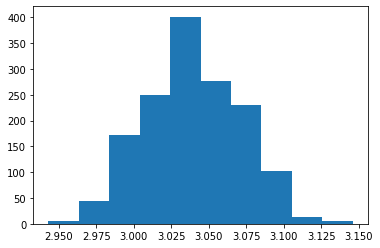

In [19]:
plt.hist(posterior_mu[int(T/2):])